# Analyzing sat scores

This proyect is about analyzing sat scores and how they correlate to other factors like the size of the school, ethnicity or percentage of native english speakers

## Preliminaries

In [1]:
!ls data

ap_2010.csv	demographics.csv  hs_directory.csv  survey_all.txt
class_size.csv	graduation.csv	  sat_results.csv   survey_d75.txt


In [2]:
# Reading the data files and importing necessary libraries.
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("data/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [3]:
# Reading text files 

all_survey = pd.read_csv("data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey


/home/dum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [4]:
# Creating the DBN columns for the class_size data set and lowercasing the name on the hs_directory

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [5]:
# Converting values stored as text to number

cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


In [6]:
# Extracting longitude and latitude and converting the data to numbers

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [7]:
# Selecting only nine graders from 2012 generations

class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [8]:
# Converting text values to numeric

cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [9]:
# Merging the datasets

combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [10]:
# Generating the district column on the combined dataset
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [11]:
# Printin existing coorelations with the sat_score

correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.sort_values())

frl_percent                            -0.722225
sped_percent                           -0.448170
ell_percent                            -0.398750
hispanic_per                           -0.396985
black_per                              -0.284139
ell_num                                -0.153778
lon                                    -0.132222
lat                                    -0.121029
com_p_11                               -0.115073
male_per                               -0.112062
zip                                    -0.063977
rr_t                                   -0.023386
eng_p_11                                0.020254
hispanic_num                            0.025744
black_num                               0.027979
sped_num                                0.034933
aca_p_11                                0.035155
eng_t_11                                0.036906
CSD                                     0.042948
rr_p                                    0.047925
com_tot_11          

In [12]:
# Plotting correlations between sat_score and the survey_fields columns

correlations[survey_fields].plot.bar()

/home/dum/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


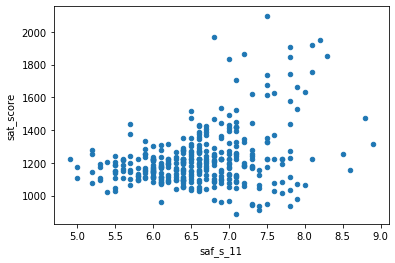

In [13]:
# There is a strong correlation between saf_t_11 and the sat_score, and also between saf_s_11 and the sat score.
# This set a relation between a safe school and the score of the sat. 

# Looking deeper into the possible relation, a scatter plot between the saf_s_11 and sat_score is made

combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

# There seems to be a possitive correlation betwwen the saf_s_11 and the sat_score

In [27]:
# Grouping the whole dataset by district and computing the mean of each of the columns

group_district = combined.groupby('school_dist')
average_safety_by_district = group_district.mean()
average_safety_by_district.reset_index(inplace = True)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


/home/dum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/home/dum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


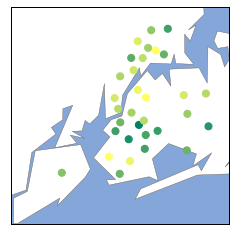

In [30]:
# A central spot in new york can be observed to have lower safety perception by the students

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = average_safety_by_district['lon'].tolist()
latitudes = average_safety_by_district['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=average_safety_by_district["saf_s_11"], cmap="summer")
plt.show()